# MyoSuite Tutorial 2023
## How to load a `MyoSuite` model, drive and visualize movements
> Copyright (c) Facebook, Inc. and its affiliates
> This source code is licensed under the Apache license found in the [LICENSE](https://github.com/facebookresearch/myosuite/blob/main/LICENSE) file.


In order to run this netebook you need to:
1. Install all the required package
2. ⚠️ Restart the runtime (if needed)
3. Run the whole sequence of cells

## 1) Installation

### Installing dependencies and `MyoSuite` in the Colab
⚠️ The first time you run this colab you might need to **restart** the environment in order to complete next steps
> Adapted from @araffin (see his colab [here](https://colab.research.google.com/drive/1KGMZdRq6AemfcNscKjgpRzXqfhUtCf-V?usp=sharing#scrollTo=MHtnurnyIwaZ))

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!apt-get update && apt-get install swig cmake
!pip install PyVirtualDisplay
!pip install sklearn tabulate matplotlib torch git+https://github.com/aravindr93/mjrl.git
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install tqdm
!pip install myosuite
import mujoco_py

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get
zsh:1: command not found: apt-get
  Cloning https://github.com/aravindr93/mjrl.git to /private/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/pip-req-build-8v2hb12a
  Running command git clone --filter=blob:none --quiet https://github.com/aravindr93/mjrl.git /private/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/pip-req-build-8v2hb12a
  Resolved https://github.com/aravindr93/mjrl.git to commit 3871d93763d3b49c4741e6daeaebbc605fe140dc
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' 

ModuleNotFoundError: No module named 'mujoco_py'

### Define a method to show the rendering inside the Colab

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 400):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")


### All the `MyoSuite` imports needed to run this tutorial

In [ ]:
import myosuite
import gym

import skvideo.io
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

## 2) Load one of the `MyoSuite` tasks
(see the complete set and descriptions [here](https://github.com/facebookresearch/myosuite/tree/main/myosuite/envs/myo))

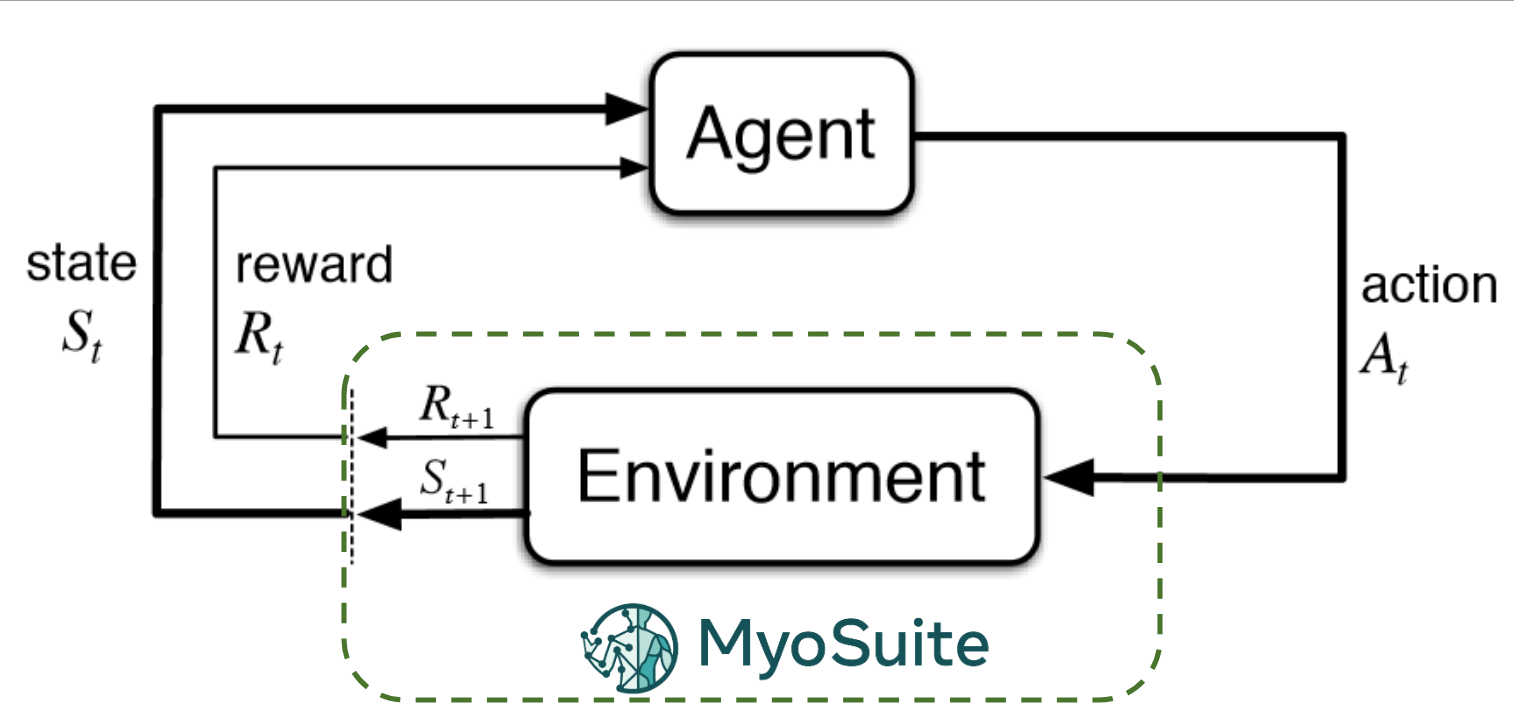

#### Creation of the environment (env)

env = gym.make(< name of the environment >)

#### Interact wiht the evnironment vias actions
state, reward, _, _ = env.step(action)

In [5]:
env = gym.make('myoElbowPose1D6MRandom-v0')
print('List of cameras available',env.sim.model.camera_names)
env.reset()
im = env.sim.render(width=400, height=400,camera_name='front_view')[::-1,:,:]
plt.imshow(im)
plt.axis('off')

NameNotFound: Environment myoElbowPose1D6MRandom doesn't exist. 

In [ ]:
env = gym.make('myoElbowPose1D6MRandom-v0')
env.reset()
# random value as an action
action = env.action_space.sample()

observation_state, reward, done, info = env.step(action)

# myoElbowPose1D6MRandom-v0 is a pose-type task
# see definition here https://github.com/facebookresearch/myosuite/blob/1d45e4d5603a70487355902450006d3bd7828d43/myosuite/envs/myo/pose_v0.py#L89

print(f"Observation dimension {len(observation_state)}")
# Observation is composed of: qpos [1], qvel [1], act [6], pose_err [1]
print(f"Observation values: {observation_state}")

# Information about the task reward
print(f"Reward value: {reward}")

# Flag to check if the task is done
print(f"Is Done: {done}")

# All the info relative to the environment i.e. reward (dense/sparse), task is solved, ...
print(f"The overall info: {info.keys()}")
# Specifically, the information relative to the state
print(f"Info contained contained the info['state']: {info['state'].keys()}")


### Generate some random movements
1. Reset the environment
2. Render the visualization of the environment
3. Send a random set of movements
4. Close the environment

In [ ]:
env = gym.make('myoElbowPose1D6MRandom-v0')
env.reset()
frames = []
for _ in tqdm(range(20)):
    frames.append(env.sim.render(width=400, height=400,camera_name='side_view')[::-1,:,:])
    env.step(env.action_space.sample()) # take a random action
env.close()

### Save the frames from the rendering and play in the Colab

The frames extreacted in the previous steps are now first stored into a mp4 file and the shown in the notebook

In [ ]:
os.makedirs('videos', exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/ElbowPose.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})

# show in the notebook
show_video('videos/ElbowPose.mp4')

## 3) Training a policy (elbow)
This cell presentes how to train and evaluate a policy

In [ ]:
import myosuite
import gym
from stable_baselines3 import PPO
env = gym.make('myoElbowPose1D6MRandom-v0')

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100)


In [ ]:
# evaluate policy
all_rewards = []
for _ in tqdm(range(20)): # 20 random targets
  ep_rewards = []
  done = False
  obs = env.reset()
  while not done:
      # get the next action from the policy
      action, _ = model.predict(obs)
      # take an action based on the current observation
      obs, reward, done, info = env.step(action)
      ep_rewards.append(reward)
  all_rewards.append(np.sum(ep_rewards))
print(f"Average reward: {np.mean(all_rewards)} over 20 episodes")


### Playback a policy
Here, a policy trained for a larger number of iterations is loaded and used to solve the tasks. Then, the results are rendered.

In [ ]:
env = gym.make('myoElbowPose1D6MRandom-v0')
# download a trained policy from the MyoSuite repo
!curl -OL "https://github.com/facebookresearch/myosuite/raw/main/myosuite/agents/baslines_NPG/myoElbowPose1D6MRandom-v0/2022-02-26_21-16-27/33_env=myoElbowPose1D6MRandom-v0,seed=1/iterations/best_policy.pickle"
policy = "best_policy.pickle"

import pickle
# load policy
pi = pickle.load(open(policy, 'rb'))

frames = []
for _ in tqdm(range(20)): # 20 random targets
  env.reset()
  ep_rewards = []
  done = False
  obs = env.reset()
  while not done:
      o = env.get_obs()
      # get the next action from the policy
      action, _ = pi.get_action(o)
      # take an action based on the current observation
      obs, reward, done, info = env.step(action)
      ep_rewards.append(reward)
  all_rewards.append(np.sum(ep_rewards))

print(f"Average reward: {np.mean(all_rewards)} over 20 episodes")


env.close()


In [ ]:
# Render trained policy
frames = []
for _ in tqdm(range(5)): # 5 random targets
  env.reset()
  ep_rewards = []
  done = False
  obs = env.reset()
  for _ in range(20):
      frame = env.sim.render(width=400, height=400,mode='offscreen', camera_name='side_view')
      frames.append(frame[::-1,:,:])
      o = env.get_obs()
      # get the next action from the policy
      action, _ = pi.get_action(o)
      # take an action based on the current observation
      obs, reward, done, info = env.step(action)

env.close()

os.makedirs('videos', exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/test_policy.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})
show_video('videos/test_policy.mp4')

## 4) Change tasks' targets
We offer all tasks in a `Fixed` (easier) and `Random` (harder) version.

In [ ]:
env_fix = gym.make('myoElbowPose1D6MFixed-v0')
env_rand = gym.make('myoElbowPose1D6MRandom-v0')

for ep in range(10):
  env_fix.reset()
  print(f"Episode {ep}, target: {env_fix.env.get_target_pose()[0]}")

for ep in range(10):
  env_rand.reset()
  print(f"Episode {ep}, target: {env_rand.env.get_target_pose()[0]}")


Often we want to test/evaluate a policy on a selected set of conditions. It is possible to change the fixed (or Random) environment to be evaulated on a fixed target.

In [ ]:
# Only for Elbow, test different posture
env = gym.make('myoElbowPose1D6MFixed-v0')
# Sequence of test angles
AngleSequence = [60, 0, 80, 30]
# Flag to enable a sequence of different fixed targets
env.env.target_type = 'fixed'

env.reset()
frames = []
for ep in tqdm(range(len(AngleSequence))):
    print("Ep {} of {} testing angle {}".format(ep, len(AngleSequence), AngleSequence[ep]))

    # Set the new target value
    env.env.target_jnt_value = [np.deg2rad(AngleSequence[int(ep)])]
    # Update the target value
    env.env.update_target()

    for _ in range(20):
        frame = env.sim.render(width=400, height=400,mode='offscreen', camera_name='side_view')
        frames.append(frame[::-1,:,:])
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, _ = env.step(a) # take an action based on the current observation
env.close()

os.makedirs('videos', exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/arm.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})
show_video('videos/arm.mp4')

## 5) Extract information about musculoskeletal model

In [ ]:
data_store = []
env.reset()
frames = []
for ep in range(len(AngleSequence)):
    print("Ep {} of {} testing angle {}".format(ep, len(AngleSequence), AngleSequence[ep]))
    env.env.target_jnt_value = [np.deg2rad(AngleSequence[int(ep)])]
    env.env.target_type = 'fixed'
    env.env.update_target()
    for _ in range(50):
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, _ = env.step(a) # take an action based on the current observation

        data_store.append({"action":a.copy(), # action / control
                            "jpos":env.sim.data.qpos.copy(), # joint position
                            "mlen":env.sim.data.actuator_length.copy(), # actuator length
                            "act":env.sim.data.act.copy()}) # actuator activations
env.close()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(411),plt.plot(np.array([d['jpos'] for d in data_store])),plt.ylabel('jpos')
plt.subplot(412),plt.imshow(np.array([d['action'] for d in data_store]).T, aspect='auto'),plt.ylabel('action')
plt.subplot(413),plt.imshow(np.array([d['act'] for d in data_store]).T, aspect='auto'),plt.ylabel('Act')
plt.subplot(414),plt.imshow(np.array([d['mlen'] for d in data_store]).T, aspect='auto'),plt.ylabel('Mlen')

plt.show()

## 6) Task variation: Sarcopenia

In [ ]:
import numpy as np
import myosuite, gym
env = gym.make('myoElbowPose1D6MFixed-v0')
dataN = []
for _ in range(5): # 5 episodes
  env.reset()
  # start from posture of 0 radiants
  env.sim.data.qpos[:] = 0
  for _ in range(200): # 200 samples
    # set an action only to elbow flexors
    a = np.array([0,0,0,.1,.1,.1])
    next_o, r, done, ifo = env.step(a)
    dataN.append({"action":a.copy(),
                "target":env.env.target_jnt_value.copy(),
                "jpos":env.sim.data.qpos.copy(),
                "mlen":env.sim.data.actuator_length.copy(),
                "act":env.sim.data.act.copy(),
                "mForce":env.sim.data.actuator_force.copy().squeeze(),
                "mForce_gain":env.sim.model.actuator_gainprm[:,2].copy()})
env.close()

env_sarc = gym.make('myoSarcElbowPose1D6MFixed-v0')
dataS = []
for _ in range(5): # 5 episodes
  env_sarc.reset()
  # start from posture of 0 radiants
  env_sarc.sim.data.qpos[:] = 0
  for _ in range(200): # 200 samples
    # set an action only to elbow flexors
    a = np.array([0,0,0,.1,.1,.1])
    next_o, r, done, info = env_sarc.step(a)
    dataS.append({"action":a.copy(),
                "target":env_sarc.env.target_jnt_value.copy(),
                "jpos":env_sarc.sim.data.qpos.copy(),
                "mlen":env_sarc.sim.data.actuator_length.copy(),
                "act":env_sarc.sim.data.act.copy(),
                "mForce":env_sarc.sim.data.actuator_force.copy().squeeze(),
                "mForce_gain":env_sarc.sim.model.actuator_gainprm[:,2].copy()})
env_sarc.close()

for ia in range(len(env.sim.model.actuator_names)):
  print(f"Muscle: {env.sim.model.actuator_names[ia]} \tForce Gain normal {env.env.sim.model.actuator_gainprm[ia,2]} with Sarcopenia {env_sarc.env.sim.model.actuator_gainprm[ia,2]}")

import matplotlib.pyplot as plt
plt.plot(np.rad2deg([v['jpos'] for v in dataN]),label='Normal'),
plt.plot(np.rad2deg([v['jpos'] for v in dataS]),label='Sarcopenia'),
plt.ylabel('Elbow angle (degrees)')
plt.xlabel('Samples')
plt.legend()
plt.show()

## 7) Advance **rendering**        

### Remove contact surfaces


In [ ]:
import myosuite, gym
env = gym.make('myoLegDemo-v0')


frame = env.sim.render(width=400, height=400,mode='offscreen', camera_name='side_view')
plt.subplot(121),plt.imshow(frame[::-1,:,:]),plt.axis('off')

# find geometries with ID == 1 which indicates the skins
geom_1_indices = np.where(env.sim.model.geom_group == 1)
# Change the alpha value to make it transparent
env.sim.model.geom_rgba[geom_1_indices, 3] = 0
frame = env.sim.render(width=400, height=400,mode='offscreen', camera_name='side_view')
plt.subplot(122),plt.imshow(frame[::-1,:,:]),plt.axis('off')



### Enable muscle activations


In [ ]:
from tqdm import tqdm_notebook as tqdm
# MuJoCo Definition of visualization options
# https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjvoption
# env.sim.render_contexts[-1].vopt
#
# Flags to enable visualization
# https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjtvisflag
# 3 --> Muscle (actuators)
env.sim.render_contexts[-1].vopt.flags[3] = 1
env.reset()
frames = []
for _ in tqdm(range(50)):
    frame = env.sim.render(width=400, height=400,mode='offscreen', camera_name='side_view')
    frames.append(frame[::-1,:,:])
    next_o, r, done, ifo = env.step(env.action_space.sample()) # take a random action
env.close()

os.makedirs('videos', exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/legs_muscle_rendering.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})
show_video('videos/legs_muscle_rendering.mp4')
